# Training with new ntuple

# prepare

## 1 - Load modules

In [1]:
import sys
sys.path.append("..") # add self-defined module in the parent path
sys.path.append("../..") # add self-defined module in the parent path
import time

from array import array
import datetime
import keras.backend
from keras.models import Sequential, Model, load_model
from keras.layers import Concatenate, Dense, Input
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adagrad, SGD, RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn import preprocessing
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from run.get_arrays import *
from lfv_pdnn_code_v1.train import model, train_utils
from lfv_pdnn_code_v1.train.train_utils import *
from lfv_pdnn_code_v1.common.common_utils import *

Using TensorFlow backend.


In [2]:
# Constants
new_bkg_path = "E:/data/new_ntuple/mc16a"
new_sig_path = "E:/data/new_ntuple/mc16a"
old_bkg_path = "E:/data/lfv/ntuples_last_run/TestData/data_npy"  # Windows can recognize both "/" and "\"
old_sig_path = "E:/data/lfv/ntuples_last_run/train_array_0909/data_npy/emu"

## 2 - Load new array
### a) load background samples

In [3]:
from run.get_arrays import *
xb_dict_new = get_new_bkg(new_bkg_path)

Loading new background array.
xb_di_boson shape: (69860, 24)
xb_top_quark shape: (68355, 24)
xb_w_jets shape: (2575, 24)
xb_z_ll shape: (407, 24)
New background organized with dict: xb_dict_new
Adding all background together.
xb shape: (141197, 24)


### b) load signal samples
when all up different signal mass point together, two method applied:
* xs: directly add each mass point signal together
* xs_norm: each mass point sample is normalized before add together/


In [4]:
from run.get_arrays import *
xs_dict_new = get_new_sig(new_sig_path)

Loading new signal array.
Organizing new signal with dict: xs_dict_new.
adding 500GeV signal to xs_dict_new (5087, 24)
adding 2000GeV signal to xs_dict_new (6293, 24)
adding all signal to xs_dict_new
adding all_norm signal to xs_dict_new
Done.


## 2 - Load old array
### a) load old background samples

In [5]:
xb_dict_old = get_old_bkg(old_bkg_path)

Loading new background array.
Organizing new background with dict: xb_dict_old.
Done.


### b) load old signal samples

In [6]:
xs_dict_old = get_old_sig(old_sig_path)

Loading old signal array.
Organizing old signal with dict: xs_dict_old.
Done.


# Make plots

## 1 - kinematic plots for emu channel

# Training Test

## 1 - Define training function.

In [12]:
selected_features_emu = [0, 1, 2, 3, 5, 6, 7, 15, 16, 17, 18, 19]
selected_features_etau = [0, 1, 2, 3, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]
selected_features_mutau = [0, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]

def train_single_mass(sig_dict, bkg_dict, channel_name, channel_id, mass_name, model_name, epochs=20,
                      selected_features = [0, 1, 2, 3, 5, 6, 7, 15, 16, 17, 18, 19], select_bkg_mass = True,
                      self_defined_mass = False, minm = None, maxm = None):
    print ("Training {}.".format(channel_name))
    # get data
    print ("Loading signal.")
    xs_emu = modify_array(sig_dict[mass_name], weight_id = -1, select_channel = True, channel_id = channel_id,
                          norm = True, sumofweight=1000, shuffle = True, shuffle_seed = int(time.time()))
    mass_min, mass_max = get_mass_range(xs_emu[:, 0], xs_emu[:, -1])
    num = 0
    total = 0
    for x in xs_emu[:, 0]:
        #if x > 15000:
        #    print "huge mass:", x
        total += x
        num += 1.0
    print (total / num)
    print ("mass average:", np.average(xs_emu[:, 0], weights=xs_emu[:, -1]))
    if self_defined_mass:
        mass_min = minm
        mass_max = maxm
    if select_bkg_mass:
        print ("Loading background with mass range:", mass_min, "to", mass_max)
    xb_emu = modify_array(bkg_dict['all'], weight_id = -1, remove_negative_weight = True, select_channel = True, channel_id = channel_id,
                          select_mass = select_bkg_mass, mass_id = 0, mass_min = mass_min, mass_max = mass_max,
                          reset_mass = True, reset_mass_array = xs_emu, reset_mass_id = 0,
                          norm = True, sumofweight=2000, shuffle = True, shuffle_seed = int(time.time()))
    # set model and train
    model_deep = model.Model_1002(model_name, len(selected_features))
    model_deep.compile()
    model_deep.prepare_array(xs_emu, xb_emu, selected_features)
    model_deep.train(epochs = epochs, val_split = 0.1, verbose = 1)
    # save model
    model_deep.save_model("E:/data/new_ntuple/model/" + model_name + ".h5")
    # performance plots
    model_deep.show_performance()
    print ("Done.")

### A) mass = 500 GeV

#### a) old ntuple
[emu]

Training emu.
Loading signal.
493.99353559718605
mass average: 493.8877268054803
Loading background with mass range: 466.9030270349735 to 520.8724265759871
c:\Users\yz622\OneDrive - mail.ustc.edu.cn\Analysis\LFV\Code\pDNN\pDNN-Code-for-LFV-v1.0\lfv_pdnn_code_v1\train\train_utils.py:159: RuntimeWarning: invalid value encountered in true_divide
  output_array = (array.copy() - average) / np.sqrt(variance)
Training array prepared.
> signal shape: (24561, 12)
> background shape: (5123, 12)
Training start. Using model: model_mass_500_emu
Model info: Sequential model optimized with old ntuple at Oct. 2rd 2019 to deal with training with full bkg mass.
Train on 21157 samples, validate on 2351 samples
Epoch 1/20
21157/21157 [==============================] - 14s 646us/step - loss: 0.0441 - acc: 0.4636 - val_loss: 0.0451 - val_acc: 0.7048
Epoch 2/20
21157/21157 [==============================] - 8s 383us/step - loss: 0.0394 - acc: 0.7423 - val_loss: 0.0420 - val_acc: 0.7541
Epoch 3/20
21157/2115

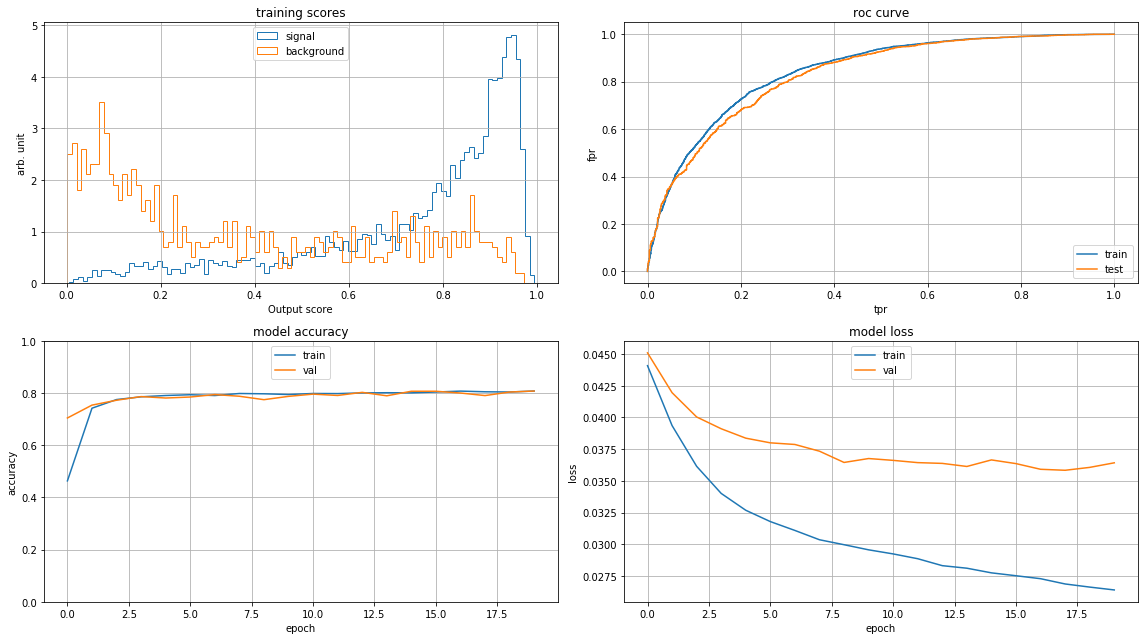

In [14]:
model_500_old = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, '500GeV', "model_mass_500_emu", epochs=20,
                                  selected_features = selected_features_emu)


*************************
[etau]

In [12]:
train_single_mass(xs_dict_old, xb_dict_old, 'etau', -3, '500GeV', "model_mass_500_etau", epochs=30, selected_features = selected_features_etau)

**********
[mutau]

In [16]:
train_single_mass(xs_dict_old, xb_dict_old, 'mutau', -2, '500GeV', "model_mass_500_mutau", epochs=30, selected_features = selected_features_mutau)

#### b) new ntuple
[emu]

In [13]:
train_single_mass(xs_dict_new, xb_dict_new, 'emu', -4, '500GeV', "model_mass_500_emu_new", epochs=30, selected_features = selected_features_emu)

***********
[etau]

In [20]:
train_single_mass(xs_dict_new, xb_dict_new, 'etau', -3, '500GeV', "model_mass_500_etau_new", epochs=30, selected_features = selected_features_etau)

*********
[mutau]

In [19]:
train_single_mass(xs_dict_new, xb_dict_new, 'mutau', -2, '500GeV', "model_mass_500_mutau_new", epochs=30, selected_features = selected_features_mutau)

### B) mass = 2000 GeV

#### a) old ntuple
[emu]

In [15]:
train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, '2000GeV', "model_mass_2000_emu", epochs=30, 
                  selected_features = selected_features_emu, select_bkg_mass = True,
                  self_defined_mass = False, minm = 1800, maxm = 2200)

*********
[etau] 

In [13]:
train_single_mass(xs_dict_old, xb_dict_old, 'etau', -3, '2000GeV', "model_mass_2000_etau", epochs=30, 
                  selected_features = selected_features_etau, select_bkg_mass = True,
                  self_defined_mass = False, minm = 1800, maxm = 2200)

*********
[mutau]

In [11]:
train_single_mass(xs_dict_old, xb_dict_old, 'mutau', -2, '2000GeV', "model_mass_2000_mutau", epochs=30, selected_features = selected_features_mutau)

#### b) new ntuple
[emu] too few background

In [16]:
train_single_mass(xs_dict_new, xb_dict_new, 'emu', -4, '2000GeV', "model_mass_2000_emu_new", epochs=30, 
                  selected_features = selected_features_emu, select_bkg_mass = True,
                  self_defined_mass = False, minm = 1800, maxm = 2200)

********
[etau]

In [68]:
train_single_mass(xs_dict_new, xb_dict_new, 'etau', -3, '2000GeV', "model_mass_2000_etau_new", epochs=30, 
                  selected_features = selected_features_etau, select_bkg_mass = True, 
                  self_defined_mass = True, minm = 1800, maxm = 2200)

*******
[mutau]

In [70]:
train_single_mass(xs_dict_new, xb_dict_new, 'mutau', -2, '2000GeV', "model_mass_2000_mutau_new", epochs=30, 
                  selected_features = selected_features_mutau, select_bkg_mass = True,
                  self_defined_mass = True, minm = 1800, maxm = 2200)

## 2 - Train with 500 GeV mass point and full mass point (use old ntuple)

### A) Train with 500 GeV single mass point
#### a) emu

In [33]:
model_single = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, '500GeV', "model_mass_500_emu_single", epochs=30, 
                                 selected_features = selected_features_emu, select_bkg_mass = True)

### B) Train with full mass point

In [42]:
model_total = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, 'all', "model_mass_all_emu", epochs=30, 
                                 selected_features = selected_features_emu, select_bkg_mass = True)

### B1) Train with full mass point, normalized before adding all mass point samples

Training emu.
Loading signal.
2032.3239913303037
mass average: 2006.469937364307
Loading background with mass range: 677.6453049537572 to 3335.294569774857
Training array prepared.
> signal shape: (703887, 12)
> background shape: (78542, 12)
Training start. Using model: model_mass_all_emu
Model info: Sequential model optimized with old ntuple at Oct. 2rd 2019 to deal with training with full bkg mass.
Train on 557713 samples, validate on 61969 samples
Epoch 1/15
557713/557713 [==============================] - 98s 175us/step - loss: 0.0019 - acc: 0.4124 - val_loss: 0.0017 - val_acc: 0.4804
Epoch 2/15
557713/557713 [==============================] - 128s 230us/step - loss: 0.0015 - acc: 0.5400 - val_loss: 0.0016 - val_acc: 0.6179
Epoch 3/15
557713/557713 [==============================] - 123s 221us/step - loss: 0.0013 - acc: 0.6494 - val_loss: 0.0015 - val_acc: 0.6829
Epoch 4/15
557713/557713 [==============================] - 147s 263us/step - loss: 0.0011 - acc: 0.7083 - val_loss: 0.0

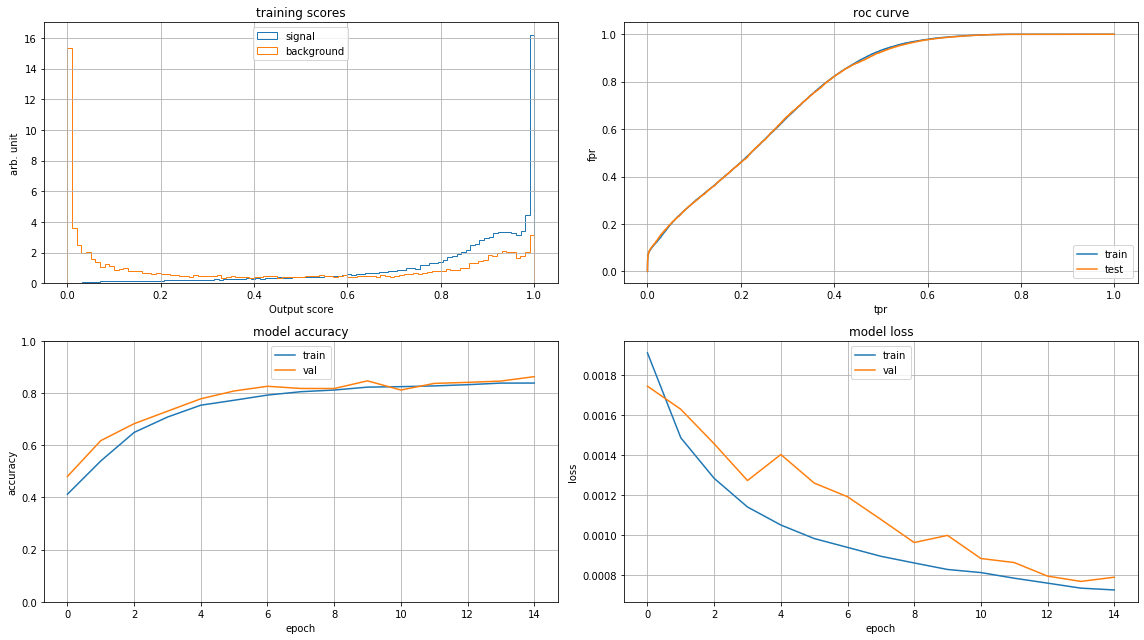

> auc for train: 0.7690637413852264
> auc for test:  0.7682193549836536
Done.


In [13]:
model_total_norm = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, 'all_norm', "model_mass_all_emu", epochs=15, 
                                 selected_features = selected_features_emu, select_bkg_mass = True)

### B2) Train with max 2400 GeV

In [62]:
model_max_2400 = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, 'max_2400', "model_mass_all_emu", epochs=30, 
                                 selected_features = selected_features_emu, select_bkg_mass = True)

### B3) Train with max 2400 GeV, normalized before adding signal samples together

In [56]:
model_max_2400_norm = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, 'max_2400_norm', "model_max_2400_norm", epochs=30, 
                                 selected_features = selected_features_emu, select_bkg_mass = True)

### B4) train with 3-point (normalized before add)
train with 500, 1000, 2000GeV

In [12]:
model_3_point_norm = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, '3_point_norm', "model_3_point_norm", epochs=30, 
                                       selected_features = selected_features_emu, select_bkg_mass = True, 
                                       self_defined_mass = True, minm = 450, maxm = 2200)

### B4) train with 4-point (normalized before add)
train with 500, 700, 1000, 2000GeV

In [18]:
model_4_point_norm = train_single_mass(xs_dict_old, xb_dict_old, 'emu', -4, '4_point_norm', "model_4_point_norm", epochs=30, 
                                       selected_features = selected_features_emu, select_bkg_mass = True, 
                                       self_defined_mass = True, minm = 450, maxm = 2200)

### C) Compare around 500GeV
set mass range to (450, 550)

In [66]:
mass_min = 450
mass_max = 550
xs_emu = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                      select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
xb_emu = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                      select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
xs_emu_selected = get_part_feature(xs_emu, selected_features_emu)
xb_emu_selected = get_part_feature(xb_emu, selected_features_emu)

# single mass train model
print "use model:", model_single.model_name
fig, ax = plt.subplots()
ax.hist(model_single.get_model().predict(xs_emu_selected), bins=50, 
        histtype='step', label='signal', density=True)
ax.hist(model_single.get_model().predict(xb_emu_selected), bins=50, 
        histtype='step', label='background', density=True)
ax.set_title('training scores')
ax.legend(loc='upper center')
ax.set_xlabel("Output score")
ax.set_ylabel("arb. unit")
ax.grid()
plt.show()

# full mass train model
print "use model:", model_total_norm.model_name
fig, ax = plt.subplots()
ax.hist(model_total_norm.get_model().predict(xs_emu_selected), bins=50, 
        histtype='step', label='signal', density=True)
ax.hist(model_total_norm.get_model().predict(xb_emu_selected), bins=50, 
        histtype='step', label='background', density=True)
ax.set_title('training scores')
ax.legend(loc='upper center')
ax.set_xlabel("Output score")
ax.set_ylabel("arb. unit")
ax.grid()
plt.show()

# below 2400 mass train model, normed
print "use model:", model_max_2400_norm.model_name
fig, ax = plt.subplots()
ax.hist(model_max_2400_norm.get_model().predict(xs_emu_selected), bins=50, 
        histtype='step', label='signal', density=True)
ax.hist(model_max_2400_norm.get_model().predict(xb_emu_selected), bins=50, 
        histtype='step', label='background', density=True)
ax.set_title('training scores')
ax.legend(loc='upper center')
ax.set_xlabel("Output score")
ax.set_ylabel("arb. unit")
ax.grid()
plt.show()

# 3 mass point train model, normed
print "use model:", model_3_point_norm.model_name
fig, ax = plt.subplots()
ax.hist(model_3_point_norm.get_model().predict(xs_emu_selected), bins=50, 
        histtype='step', label='signal', density=True)
ax.hist(model_3_point_norm.get_model().predict(xb_emu_selected), bins=50, 
        histtype='step', label='background', density=True)
ax.set_title('training scores')
ax.legend(loc='upper center')
ax.set_xlabel("Output score")
ax.set_ylabel("arb. unit")
ax.grid()

## 3 - train with new and old signal to see the result

### A) 500GeV

In [10]:
print "Training new_vs_old. ({})".format("emu")
# get data
print "Loading signal."
xs_emu_new = modify_array(xs_dict_new['500GeV'], weight_id = -1, select_channel = True, channel_id = -4,
                          norm = True, shuffle = True, shuffle_seed = int(time.time()))
xs_emu_old = modify_array(xs_dict_old['500GeV'], weight_id = -1, select_channel = True, channel_id = -4,
                          norm = True, shuffle = True, shuffle_seed = int(time.time()))
# set model and train
model_deep = model.model_0913("new_vs_old", len(selected_features_emu))
model_deep.compile()
model_deep.prepare_array(xs_emu_new, xs_emu_old, selected_features_emu)
model_deep.train(epochs = 30, verbose = 1)
# performance plots
model_deep.show_performance()
print "\nDone."

print "Training old_vs_new.".format("emu")
# set model and train
model_deep = model.model_0913("olg_vs_new", len(selected_features_emu))
model_deep.compile()
model_deep.prepare_array(xs_emu_old, xs_emu_new, selected_features_emu)
model_deep.train(epochs = 30, verbose = 1)
# performance plots
model_deep.show_performance()
print "\nDone."

### B) 2000 GeV

In [11]:
print "Training new_vs_old. ({})".format("emu")
# get data
print "Loading signal."
xs_emu_new = modify_array(xs_dict_new['2000GeV'], weight_id = -1, select_channel = True, channel_id = -4,
                          norm = True, shuffle = True, shuffle_seed = int(time.time()))
xs_emu_old = modify_array(xs_dict_old['2000GeV'], weight_id = -1, select_channel = True, channel_id = -4,
                          norm = True, shuffle = True, shuffle_seed = int(time.time()))
# set model and train
model_deep = model.model_0913("new_vs_old_2000", len(selected_features_emu))
model_deep.compile()
model_deep.prepare_array(xs_emu_new, xs_emu_old, selected_features_emu)
model_deep.train(epochs = 30, verbose = 1)
# performance plots
model_deep.show_performance()
print "\nDone."

print "Training old_vs_new.".format("emu")
# set model and train
model_deep = model.model_0913("olg_vs_new_2000", len(selected_features_emu))
model_deep.compile()
model_deep.prepare_array(xs_emu_old, xs_emu_new, selected_features_emu)
model_deep.train(epochs = 30, verbose = 1)
# performance plots
model_deep.show_performance()
print "\nDone."

## 4 Plot auc vs mass (with full mass train & 3-point mass train)
### A) Use model_total_norm (full mass train)
use mass +- 50GeV bin 

In [44]:
model_used = model_total_norm

xs_emu = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                      select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
xb_emu = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                      select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
xs_emu_selected = get_part_feature(xs_emu, selected_features_emu)
xb_emu_selected = get_part_feature(xb_emu, selected_features_emu)
mass_list = []
auc_list = []
for i in range(0, 16):
    mass = i * 100 + 500
    mass_min = mass - 50
    mass_max = mass + 50
    xs_emu = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                          select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
    xb_emu = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                          select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
    xs_emu_selected = get_part_feature(xs_emu, selected_features_emu)
    xb_emu_selected = get_part_feature(xb_emu, selected_features_emu)
    ys_emu = np.ones(len(xs_emu_selected))
    yb_emu = np.zeros(len(xb_emu_selected))
    x_emu = np.concatenate((xs_emu_selected, xb_emu_selected))
    y_emu = np.concatenate((ys_emu, yb_emu))
    predicti_y = model_used.get_model().predict(x_emu)
    fpr, tpr, threshold = roc_curve(y_emu, predicti_y)
    auc_value = auc(fpr, tpr)
    mass_list.append(mass)
    auc_list.append(auc_value)
plt.plot(mass_list, auc_list)
plt.ylim((0, 1))
plt.xlabel("mass GeV")
plt.ylabel("auc")
plt.show()

### B) Use model_3_point_norm (3-point mass train)
use mass +- 50GeV bin 

In [20]:
model_used = model_3_point_norm

mass_list = []
auc_list = []
for i in range(0, 16):
    mass = i * 100 + 500
    mass_min = mass - 50
    mass_max = mass + 50
    xs_emu = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                          select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
    xb_emu = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                          select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
    xs_emu_selected = get_part_feature(xs_emu, selected_features_emu)
    xb_emu_selected = get_part_feature(xb_emu, selected_features_emu)
    ys_emu = np.ones(len(xs_emu_selected))
    yb_emu = np.zeros(len(xb_emu_selected))
    x_emu = np.concatenate((xs_emu_selected, xb_emu_selected))
    y_emu = np.concatenate((ys_emu, yb_emu))
    predicti_y = model_used.get_model().predict(x_emu)
    fpr, tpr, threshold = roc_curve(y_emu, predicti_y)
    auc_value = auc(fpr, tpr)
    mass_list.append(mass)
    auc_list.append(auc_value)
plt.plot(mass_list, auc_list)
plt.ylim((0, 1))
plt.xlabel("mass GeV")
plt.ylabel("auc")
plt.show()

### B) Use model_4_point_norm (4-point mass train)
use mass +- 50GeV bin 

In [21]:
model_used = model_4_point_norm

mass_list = []
auc_list = []
for i in range(0, 16):
    mass = i * 100 + 500
    mass_min = mass - 50
    mass_max = mass + 50
    xs_emu = modify_array(xs_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                          select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
    xb_emu = modify_array(xb_dict_old['all'], weight_id = -1, select_channel = True, channel_id = -4,
                          select_mass = True, mass_id = 0, mass_min = mass_min, mass_max = mass_max)
    xs_emu_selected = get_part_feature(xs_emu, selected_features_emu)
    xb_emu_selected = get_part_feature(xb_emu, selected_features_emu)
    ys_emu = np.ones(len(xs_emu_selected))
    yb_emu = np.zeros(len(xb_emu_selected))
    x_emu = np.concatenate((xs_emu_selected, xb_emu_selected))
    y_emu = np.concatenate((ys_emu, yb_emu))
    predicti_y = model_used.get_model().predict(x_emu)
    fpr, tpr, threshold = roc_curve(y_emu, predicti_y)
    auc_value = auc(fpr, tpr)
    mass_list.append(mass)
    auc_list.append(auc_value)
plt.plot(mass_list, auc_list)
plt.ylim((0, 1))
plt.xlabel("mass GeV")
plt.ylabel("auc")
plt.show()

# test area

In [ ]:
test_dict = {}
a = 1
b = 2
test_dict['a'] = a
test_dict['b'] = b
print test_dict

a = 10
b = 20
print test_dict

test_dict['a'] = 100
print test_dict
print a

In [ ]:
from lfv_pdnn_code_v1.common import print_helper

print_helper.print_warning("test  warning")

In [18]:
test_list = ["a", 'b', 'c']
print 'a' in test_list

In [1]:
import datetime

print datetime.date.today().strftime("_%m_%d_%Y")

In [20]:
import os
test_path = "/mnt/asdfasfas"
print os.path.split(test_path)[0]

In [13]:
oldmapp = np.array( [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,24,26,28,30,35,40,45,50])
newmapp = (oldmapp * 100)
for i in newmapp:
    print("{}, ".format(i), end=""),

500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2200, 2400, 2600, 2800, 3000, 3500, 4000, 4500, 5000,

In [10]:
print (xb_dict_old['all'].shape)

(288847, 24)


In [11]:
print (xs_dict_old['all_norm'].shape)

(716622, 24)
